In [702]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import sys

VALOR_CAMBIO_A_DOLAR = 19.54

In [703]:
df = pd.read_csv('train.csv',
        index_col='id',
        dtype={'gimnasio': bool,
                'usosmultiples': bool,
                'escuelascercanas': bool,
                'piscina': bool,
                'centroscomercialescercanos': bool,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
pd.set_option('display.float_format', '{:.2f}'.format)

In [704]:
df['tipodepropiedad'].isin(['Apartamento'])

id
254099     True
53461     False
247984    False
209067    False
185997     True
          ...  
119879    False
259178    False
131932     True
146867    False
121958     True
Name: tipodepropiedad, Length: 240000, dtype: bool

In [705]:
df.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [706]:
# Me quedo solo con las columnas que son importantes para nuestro analisis.
# Quizas el titulo y la descripcion tampoco las use, pero primero habria que hacer  un analisis de ese campo
df.drop(['direccion','idzona','lat','lng'], axis=1, inplace=True)

In [707]:
df.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio'],
      dtype='object')

In [708]:
# 1. Ver cuantos datos (observaciones) tenemos en total
# 2. Ver cuantos atributos tiene cada observaci´on
# 3. Ver el nombre y tipo de dato de cada observaci´on
# 4. Ver cuantos valores faltantes existen y en que proporci´on se presentan para
# cada atributo
# Despues de parsear y filtrar los nulos, deberiamos poner cada columna en su tipo ideal.
# df['antiguedad'] = df['antiguedad'].astype(int)     algo de este estilo

print("Filas, columnas: ", df.shape)
print("Tipos: \n", df.dtypes)

Filas, columnas:  (240000, 18)
Tipos: 
 titulo                                object
descripcion                           object
tipodepropiedad                     category
ciudad                              category
provincia                           category
antiguedad                           float64
habitaciones                         float64
garages                              float64
banos                                float64
metroscubiertos                      float64
metrostotales                        float64
fecha                         datetime64[ns]
gimnasio                                bool
usosmultiples                           bool
piscina                                 bool
escuelascercanas                        bool
centroscomercialescercanos              bool
precio                               float64
dtype: object


Text(0.5, 1.0, 'Cantidad de nulos por columna')

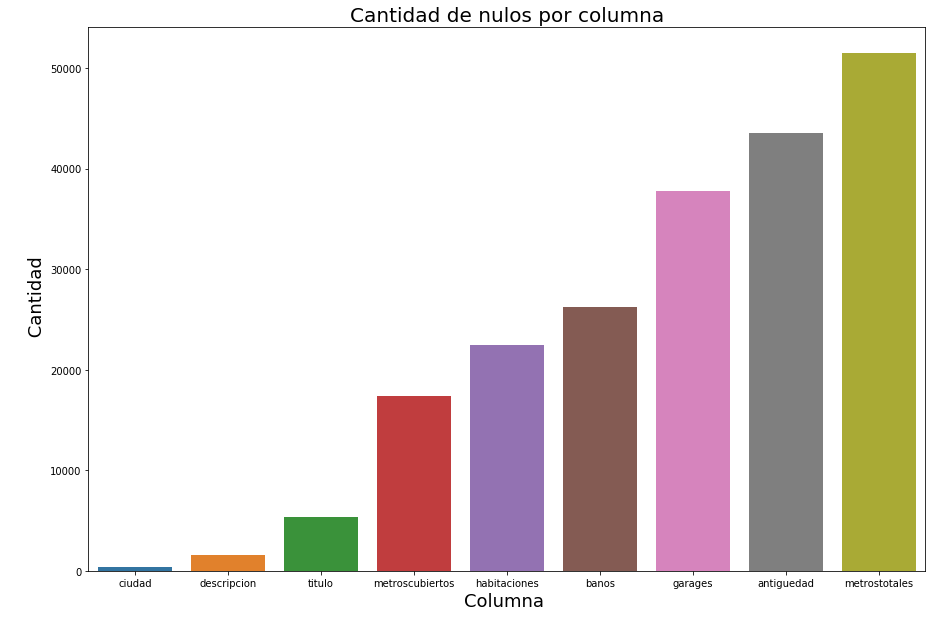

In [709]:
# Cosas a observar de esto:
# Propiedades sin ciudad ni provincia.
# Muchas propiedades sin metroscubiertos y totales especificados. Estas columnas son claves para 
# el precio (falta demostrar)
# 46 propiedades sin clasificacion de tipo de propiedad. 
# Habitaciones y Banos, muchos datos nulos. Sera que no tienen? Una casa no pude no tener habitacio ni bano...
# Garages, piscina, salondeusosmultiples y gimnasio son extras. Supongo que el hecho de que no aparezcan 
# es que no los tienen.
# Estos 4 extras, podrian reunirse en una categoria todas juntas para evaluar como crece el precio en base a esos
# extras.
# 43000 propiedades sin saber su antiguedad. Esto si ni idea como podemos reemplazarlos.

df_nulos = df.isnull().sum().to_frame().reset_index().rename(columns={'index':'Columna',0:'Cantidad de nulos'})
df_nulos = df_nulos[df_nulos['Cantidad de nulos']>200].sort_values(by='Cantidad de nulos')

plt.figure(figsize=(15,10))
ax = sns.barplot(data=df_nulos, x='Columna', y='Cantidad de nulos')
#ax.set(xlabel='\n Columna ', ylabel='Cantidad \n')
ax.set_xlabel('Columna \n', fontsize=18)
ax.set_ylabel('\n Cantidad', fontsize=18)
ax.set_title('Cantidad de nulos por columna', fontdict={'fontsize':20})


In [710]:
df_nulos = df.isnull().sum().to_frame().reset_index().rename(columns={'index':'Columna',0:'Cantidad de nulos'})
df_nulos

,Columna,Cantidad de nulos
0,titulo,5387
1,descripcion,1619
2,tipodepropiedad,46
3,ciudad,372
4,provincia,155
5,antiguedad,43555
6,habitaciones,22471
7,garages,37765
8,banos,26221
9,metroscubiertos,17400


In [711]:
# Dato importante y valioso: No hay ninguna casa que no tenga especificado ni metros cubiertos ni totales
# Esto me asegura que no tengo que limpiar datos, ya que si no hubiese tenido ninguno hubiese sido dato invalido
# Conociendo uno de los dos valores, puedo intentar asumir el otro con alguna decision.
df[(df['metroscubiertos'].isnull()) & (df['metrostotales'].isnull())].head()

,titulo,descripcion,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,,,,


Text(0.5, 1.0, 'Cantidad de metros cubiertos nulos por tipo de propiedad')

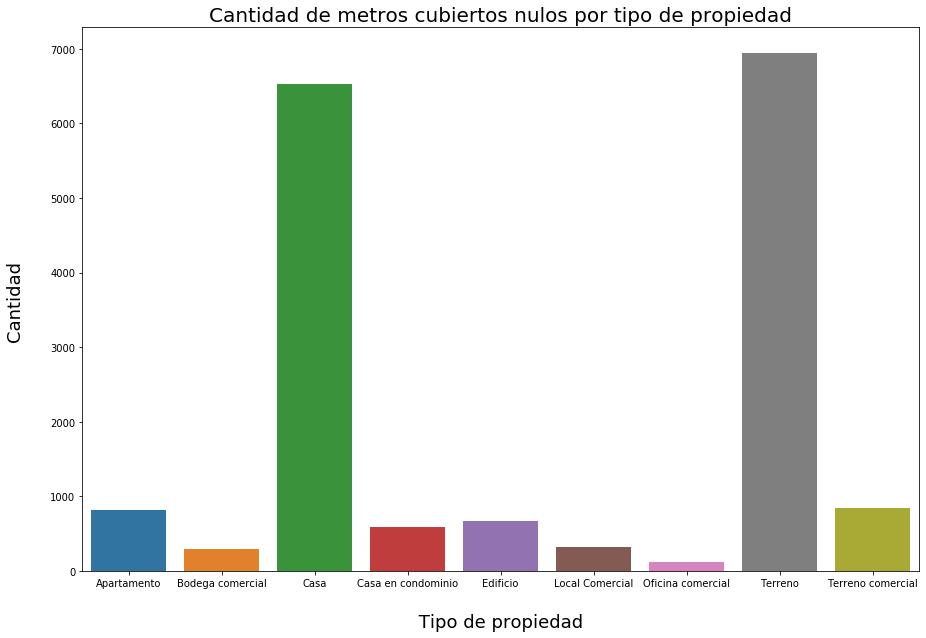

In [712]:
# Tiene sentido que los terrenos no tengan metros cubiertos. 
# Pero como una casa, un edificio, y cualquier otra cosa que no sea un terreno no tiene metros cubiertos? 
# Y ya demostre en uno de los graficos que los metros cubiertos y totales son lo que mas influyen en el precio. 
# Esto, a mi criterio, convierte estos datos en invalidos.
df_nulos_metroscub_tipoprop = df[df.metroscubiertos.isnull()]['tipodepropiedad'].value_counts().to_frame().reset_index().rename(columns={'index':'Tipo de propiedad', 'tipodepropiedad': 'Cantidad de nulos'})
df_nulos_metroscub_tipoprop = df_nulos_metroscub_tipoprop[df_nulos_metroscub_tipoprop['Cantidad de nulos']>100]

df_nulos_metroscub_tipoprop['Tipo de propiedad'].cat.remove_unused_categories(inplace=True)

df_nulos_metroscub_tipoprop.sort_values(by='Cantidad de nulos', inplace=True)

df_nulos_metroscub_tipoprop.reset_index(inplace=True)

plt.figure(figsize=(15,10))
ax = sns.barplot(data=df_nulos_metroscub_tipoprop, x='Tipo de propiedad', y='Cantidad de nulos')
ax.set(xlabel='\n Tipo de propiedad ', ylabel='Cantidad \n')
ax.set_xlabel('\n Tipo de propiedad ', fontsize=18)
ax.set_ylabel('Cantidad \n', fontsize=18)
ax.set_title('Cantidad de metros cubiertos nulos por tipo de propiedad', fontdict={'fontsize':20})

In [713]:
# Extraigo todos aquellas propiedades que tienen metroscubiertos nulos y no son terrenos. 
# Quizas en vez de extraerlos, se podria asumir que los metros totales son todos cubiertos.
indices_invalidos = df[(df.metroscubiertos.isnull()) & (~df.tipodepropiedad.isin(['Terreno','Terreno comercial']))].index
df.drop(index=indices_invalidos, inplace=True)
df.shape

(230391, 18)

In [714]:
# No tiene sentido que una casa no tenga ciudad ni provincia, ya que son datos que influyen en el precio
# y no se pueden deducir de otro lado, ademas, son pocos
df.dropna(subset=['ciudad','provincia'], inplace=True)
df.shape

(230055, 18)

In [715]:
# Es imposible que cualquier inmueble tenga metroscubiertos, y no tenga metros totales.
# Para esos casos, le asigno la misma cantidad de metros cubiertos que totales, osea no tiene metros descubiertos.
df['metrostotales'].fillna(df['metroscubiertos'], inplace=True)

In [716]:
# Despues de estos pequeños arreglos, se reducen la cantidad de nulos. Si bien siguen habiendo, 
df.isnull().sum()

titulo                         5071
descripcion                    1484
tipodepropiedad                  19
ciudad                            0
provincia                         0
antiguedad                    41416
habitaciones                  20540
garages                       34150
banos                         23077
metroscubiertos                7777
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [717]:
# El resto de filas con metros cubiertos, son terrenos. Deberian tener 0 metros cubiertos.
df['metroscubiertos'].fillna(0, inplace=True)

In [718]:
# Aquellas casas que no tienen el tipodepropiedad, son solo 19. Podria intentar sacar el tipo de prop
# desde la descripcion pero no estaria seguro al respecto. Siendo solo 19, las elimino.
df.dropna(subset=['tipodepropiedad'],inplace=True)

In [719]:
df.shape

(230036, 18)

In [720]:
# Para banos y habitaciones, completo los nulos con la moda agrupando por tipo de propiedad y ciudad.
# En caso de que no este en ninguno de esos, le asigno la moda por tipo de propiedad.

df['banos'] = df.groupby(['tipodepropiedad','ciudad'])['banos'].transform(lambda x: x.fillna(x.mode()))
df['habitaciones'] = df.groupby(['tipodepropiedad','ciudad'])['habitaciones'].transform(lambda x: x.fillna(x.mode()))
df['banos'] = df.groupby(['tipodepropiedad'])['banos'].transform(lambda x: x.fillna(x.mode()))
df['habitaciones'] = df.groupby(['tipodepropiedad'])['habitaciones'].transform(lambda x: x.fillna(x.mode()))

In [721]:
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                  20533
garages                       34135
banos                         23063
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [722]:
# 17964 registros sin banos ni habitaciones completados. Analizo eso:
# Hay alguno con ambos nulos?
df[(df.banos.isnull())&(df.habitaciones.isnull())].shape
# Esos 17964 coinciden.

(16294, 18)

In [723]:
# Registros sin baño agrupados por tipo de propiedad.
df[df.banos.isnull()].groupby('tipodepropiedad').size()

tipodepropiedad
Apartamento                      1220
Bodega comercial                  469
Casa                             6897
Casa en condominio                687
Casa uso de suelo                 112
Departamento Compartido             6
Duplex                              5
Edificio                          462
Huerta                             12
Inmuebles productivos urbanos      96
Local Comercial                  1532
Local en centro comercial         118
Lote                                0
Nave industrial                    25
Oficina comercial                 693
Otros                              35
Quinta Vacacional                  48
Rancho                             32
Terreno                          9417
Terreno comercial                1143
Terreno industrial                 14
Villa                              38
Hospedaje                           1
Garage                              1
dtype: int64

In [724]:
# Causalmente, todos esos nulos corresponden a inmuebles no habitables. Es raro suponer que no tienen baño, pero asumimos
# que ese None, es algo que no modifica el valor del inmueble. No cambia para un local su valor si tiene o no baño.
df[df.habitaciones.isnull()].groupby('tipodepropiedad').size().sum()

20533

In [725]:
# La idea es ver si alguno que no sea habitable, tiene baños distinto de None para ver como reemplazar los otros nan.
# Por habitable me refiero a propiedades donde vive gente.

habitables = ['Casa','Apartamento','Casa en condominio','Casa uso de suelo','Quinta Vacacional','Villa','Duplex','Rancho','Departamento Compartido']

df[~df.tipodepropiedad.isin(habitables)]['habitaciones'].value_counts()

3.00     376
1.00     361
2.00     360
4.00     213
5.00     122
6.00      87
10.00     63
8.00      42
7.00      33
9.00      26
Name: habitaciones, dtype: int64

In [726]:
# Tomo la decision de llenar los banos y habitaciones nulos, ya demostrado que corresponden a inmuebles no habitables,
# con el valor 0. Al margen de llenar los nulos, clarmaente son datos que no van a interesar para el analisis de este tipo de 
# propiedades.
df.banos.fillna(0, inplace = True)
df.habitaciones.fillna(0, inplace = True)

In [727]:
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                      0
garages                       34135
banos                             0
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [728]:
# Ahora voy a analizar los garages nulos. 
df[df.garages.isnull()].groupby('tipodepropiedad').size()

tipodepropiedad
Apartamento                       3543
Bodega comercial                   393
Casa                             21600
Casa en condominio                2973
Casa uso de suelo                  189
Departamento Compartido              4
Duplex                               7
Edificio                           233
Huerta                               5
Inmuebles productivos urbanos       45
Local Comercial                   1060
Local en centro comercial           42
Lote                                 0
Nave industrial                     18
Oficina comercial                  473
Otros                               48
Quinta Vacacional                  237
Rancho                              93
Terreno                           2397
Terreno comercial                  604
Terreno industrial                  17
Villa                              154
Hospedaje                            0
Garage                               0
dtype: int64

In [729]:
# De aca se puede ver informacion importante: Segun la ciudad y el tipo de propiedad, varia bastante la cantidad de garages
# de una casa.
df.groupby(['tipodepropiedad','ciudad']).agg({'garages':'mean'})

garages
tipodepropiedad ciudad                          
Apartamento     Abalá                        nan
                Abasolo                      nan
                Acajete                     1.00
                Acambay                     2.00
                Acapulco de Juárez          1.29
...                                          ...
Garage          San Luis de la Paz           nan
                San Matías Tlalancaleca      nan
                San Pedro                    nan
                Sombrerete                   nan
                ZirAndaro                    nan

[21000 rows x 1 columns]

In [730]:
# Tomo la decision de completar aquellos valores de garage nulos, con el promedio de garages para ese tipo de propiedad,
# en la ciudad en que se encuentre.
df['garages'] = df.groupby(['tipodepropiedad','ciudad'])['garages'].transform(lambda x: x.fillna(x.mode()))

df['banos'].value_counts()

2.00    85887
1.00    56953
3.00    47212
0.00    23063
4.00    16921
Name: banos, dtype: int64

In [731]:
# Para aquellos registros que registraban de promedio nan, osea ninguno tenia, los relleno con 0 como valor de garage.
df['garages'].fillna(0, inplace=True)

In [732]:
# Solo me queda revisar los nulos de antiguedad. Son muchisimos. 
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [733]:
# La decision que voy a tomar para esos nulos, es similar a la de los garages. Voy a rellenar los nulos con el promedio
# de antiguedad para ese tipo de propiedad y esa ciudad en la que esta ubicada la propiedad.
# No se que tanto sentido tenga asignarle valores asi a la antiguedad porque de verdad estoy modificando de una forma que
# no necesariamente sea correcta


# df.groupby(['tipodepropiedad','ciudad']).agg({'antiguedad':'mean'})

In [734]:
# df['antiguedad'] = df.groupby(['tipodepropiedad','ciudad'])['antiguedad'].transform(lambda x: x.fillna(x.mean()))

In [735]:
df.isnull().sum()

titulo                         5071
descripcion                    1483
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    41400
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [736]:
# Se puede ver mucha informacion importante aca. 
# Por ejemplo, la diferencia abismal que hay entre el tercer cuantil y el maximo de precio.
# Deberia seguir mirando un poco mas
df.describe()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,precio
count,188636.00,230036.00,230036.00,230036.00,230036.00,230036.00,230036.00
mean,8.03,2.62,1.32,1.90,168.10,173.75,2449120.60
std,9.45,1.16,0.95,1.07,101.47,96.54,2060857.69
min,0.00,0.00,0.00,0.00,0.00,15.00,310000.00
25%,0.00,2.00,0.00,1.00,86.00,97.00,950000.00
50%,5.00,3.00,1.00,2.00,150.00,150.00,1800000.00
75%,10.00,3.00,2.00,3.00,236.00,235.00,3250000.00
max,80.00,10.00,3.00,4.00,439.00,439.00,12525000.00


In [737]:
# Antes de empezar a analizar los datos, deberia intentar detectar outliers en cuanto al precio.
print('El percentil 0.99: ',df.precio.quantile(0.99))
print('El percentil 0.01: ',df.precio.quantile(0.01))
print('El maximo: ', df.precio.max())
print('El minimo: ', df.precio.min())
print('Maximo / Percentil 0.99', df.precio.max()/df.precio.quantile(0.99))
print('Percentil 0.01 / Minimo', df.precio.quantile(0.01)/df.precio.min())
print('Cantidad de registros por debajo del percentil 0.01: ', df[df['precio']<df.precio.quantile(0.01)].shape)
print('Cantidad de registros por encima del percentil 0.99: ', df[df['precio']>df.precio.quantile(0.99)].shape)

El percentil 0.99:  10000000.0
El percentil 0.01:  340000.0
El maximo:  12525000.0
El minimo:  310000.0
Maximo / Percentil 0.99 1.2525
Percentil 0.01 / Minimo 1.096774193548387
Cantidad de registros por debajo del percentil 0.01:  (2181, 18)
Cantidad de registros por encima del percentil 0.99:  (2140, 18)


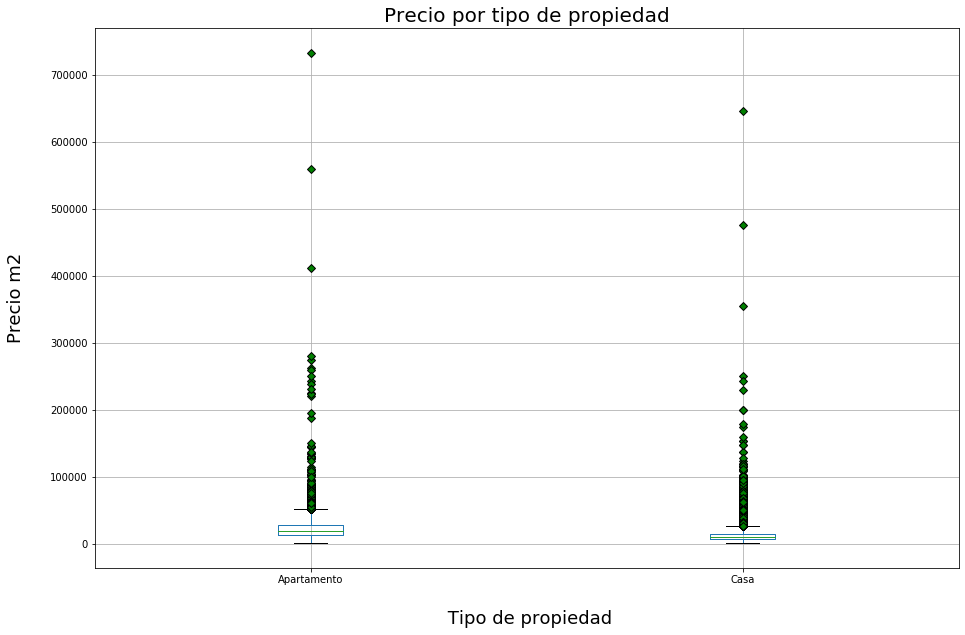

In [738]:
# Un boxplot ayuda a poder detectar estos outliers.

df['precio_m2'] = df['precio']/df['metrostotales']

def plot_outliers(df):
    fig, ax = plt.subplots(figsize=(15,10))
    green_diamond = dict(markerfacecolor='g', marker='D')
    df_g1 = df.copy()
    df_g1 = df[df['tipodepropiedad'].isin(['Casa','Apartamento','Edificio','Casa en condominio','Duplex','Terreno','Terreno comercial'])]
    df_g1.tipodepropiedad.cat.remove_unused_categories(inplace=True)
    df_g1.boxplot(column='precio_m2', by='tipodepropiedad', ax=ax, flierprops=green_diamond)
    ax.set_title('Precio por tipo de propiedad', fontdict={'fontsize':20})
    fig.suptitle('')
    ax.set_xlabel('\n Tipo de propiedad', fontsize=18)
    ax.set_ylabel('Precio m2\n', fontsize=18)
    
plot_outliers(df)

In [739]:
# Filtro los outliers, usando maximos y minimos en base al cuantil 1 y 3 y el IQR.
print('Antes de filtrar: ', df.shape)

def is_outlier(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    precio_min = Q1 - 1.5 * IQR
    precio_max = Q3 + 1.5 * IQR
    return ~group.between(precio_min, precio_max)

df = df[~df.groupby('tipodepropiedad')['precio_m2'].apply(is_outlier)]

print('Despues de filtrar: ', df.shape)

Antes de filtrar:  (230036, 19)
Despues de filtrar:  (220413, 19)


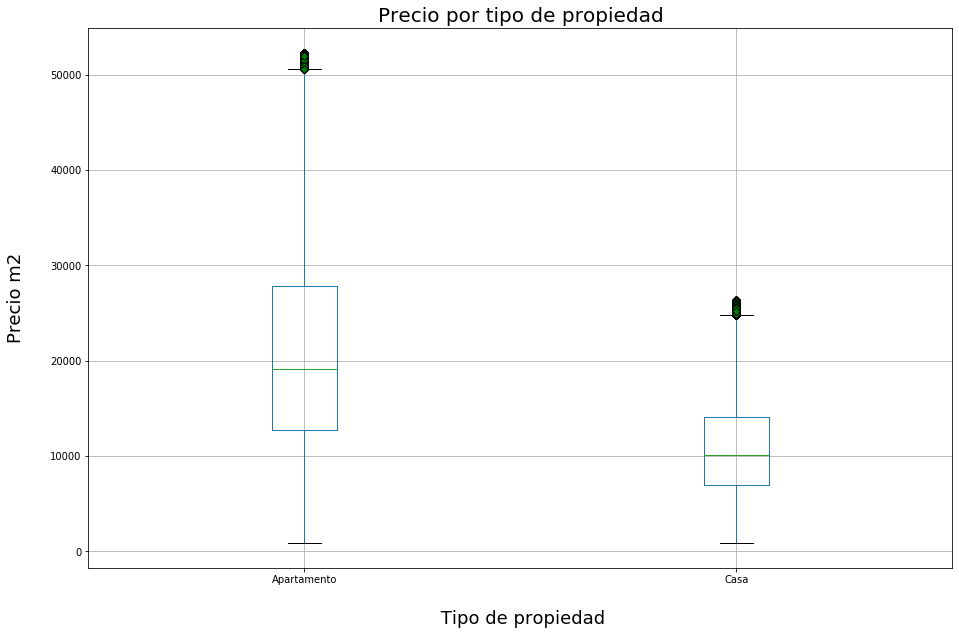

In [740]:
# Vuelvo a graficar, para ver como cambiaron los outliers.
plot_outliers(df)

In [741]:
#Lleno los nulos de antiguedad con 0. Supongo que son todos nuevos.
df['antiguedad'].fillna(0, inplace=True)

# Quedaron solo 517 con antiguedad nula. Los reviso:
# df[df['antiguedad'].isnull()]

# Para estos restantes, tomo la decision de rellenarlos de acuerdo a el promedio de antiguedad segun el tipo de prop y la prov

# df['antiguedad'] = df.groupby(['tipodepropiedad','provincia'])['antiguedad'].transform(lambda x: x.fillna(x.mean()))

In [742]:
# df.isnull().sum()

In [743]:
# Los restantes, los elimino ya que son pocos y no puedo fijarle una antiguedad de forma tan directa
# df.dropna(subset=['antiguedad'], inplace=True)

In [744]:
df.isnull().sum()

titulo                        4900
descripcion                   1437
tipodepropiedad                  0
ciudad                           0
provincia                        0
antiguedad                       0
habitaciones                     0
garages                          0
banos                            0
metroscubiertos                  0
metrostotales                    0
fecha                            0
gimnasio                         0
usosmultiples                    0
piscina                          0
escuelascercanas                 0
centroscomercialescercanos       0
precio                           0
precio_m2                        0
dtype: int64

In [745]:
# Hay 70000 filas en las que los metros totales son menores a los cubiertos. Esto es invalido. La realidad es que son muchas
# filas, por lo tano les seteo como metros totales, la misma cantidad que cubiertos.

df.loc[df['metrostotales']<df['metroscubiertos'], 'metrostotales'] = df['metroscubiertos']


In [746]:
# Aca deberia ir seteando las columnas nuevas que me parezcan utiles para analisis.
# Ideas: Precio por metro total, o agregar una columna con la cantidad de extras que tenga la casa.
df['precio_dolar'] = df['precio']/VALOR_CAMBIO_A_DOLAR
df['precio_m2'] = df['precio']/df['metrostotales']
df['extras'] = df['garages']+df['piscina']+df['usosmultiples']+df['gimnasio']
